#### Örnek Veri Setinin Hazırlanması
Iris veri seti, üç farklı türden 150 iris çiçeğinin ölçümlerini içerir.

###### Iris veri kümesindeki üç sınıf:<br>

###### Iris-setosa(n=50)<br>
###### Iris-versicolor(n=50)<br>
###### Iris-virginica(n=50)<br>

![](https://i.imgur.com/GGGCzaa.png)

In [2]:
feature_dict = {i:label for i,label in zip(
                range(4),
                  ('sepal length in cm',
                  'sepal width in cm',
                  'petal length in cm',
                  'petal width in cm', ))}


In [3]:
import pandas as pd

df = pd.io.parsers.read_csv(
    filepath_or_buffer='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
    header=None,
    sep=',',
    )
df.columns = [l for i,l in sorted(feature_dict.items())] + ['class label']
df.dropna(how="all", inplace=True)

df.tail()

,sepal length in cm,sepal width in cm,petal length in cm,petal width in cm,class label
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


![link](https://i.imgur.com/P6uMAAE.png)

Numerik değerlerle çalışmak daha uygun olduğundan, sınıf etiketlerini sayısal değerlere dönüştürmek için scikit-learn kütüphanesinden LabelEncode'i kullanacağız: 1, 2 ve 3.

In [4]:
from sklearn.preprocessing import LabelEncoder

X = df.iloc[:, :4].values
y = df.iloc[:, 4].values


enc = LabelEncoder()
label_encoder = enc.fit(y)
y = label_encoder.transform(y) + 1

label_dict = {1: 'Setosa', 2: 'Versicolor', 3:'Virginica'}

![](https://i.imgur.com/5AWx8af.png)

Histogramlar ve özellik seçimi

Üç sınıf ω1, ω2 ve ω3'nün örneklerinin nasıl dağıldığını genel olarak anlamak için, dört farklı özelliğin dağılımlarını 1-boyutlu histogramlarla görselleştirelim.

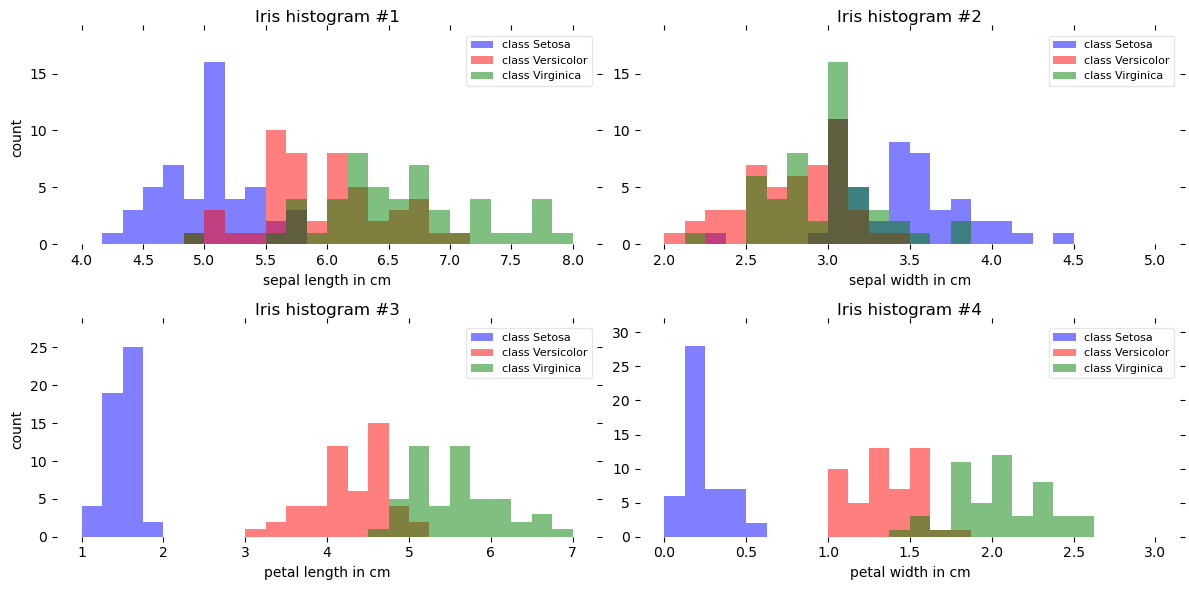

In [5]:
from matplotlib import pyplot as plt
import numpy as np
import math

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,6))

for ax,cnt in zip(axes.ravel(), range(4)):  

    # set bin sizes
    min_b = math.floor(np.min(X[:,cnt]))
    max_b = math.ceil(np.max(X[:,cnt]))
    bins = np.linspace(min_b, max_b, 25)

    # plottling the histograms
    for lab,col in zip(range(1,4), ('blue', 'red', 'green')):
        ax.hist(X[y==lab, cnt],
                   color=col,
                   label='class %s' %label_dict[lab],
                   bins=bins,
                   alpha=0.5,)
    ylims = ax.get_ylim()

    # plot annotation
    leg = ax.legend(loc='upper right', fancybox=True, fontsize=8)
    leg.get_frame().set_alpha(0.5)
    ax.set_ylim([0, max(ylims)+2])
    ax.set_xlabel(feature_dict[cnt])
    ax.set_title('Iris histogram #%s' %str(cnt+1))

    # hide axis ticks
    ax.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

axes[0][0].set_ylabel('count')
axes[1][0].set_ylabel('count')

fig.tight_layout()       

plt.show()

Bu basit grafiksel gösterimlerden, taç-yaprak uzunlukları ve genişliklerinin üç çiçek sınıfı arasında daha iyi ayrım yapmak için daha uygun olabileceğini hemen anlayabiliriz. Uygulamada, boyut azaltmayı(burada LDA) bir projeksiyon yoluyla değil, özellik seçimi ile gerçekleştirmek daha iyi bir alternatiftir. Iris gibi düşük boyutlu veri kümeleri için, bu histogramlara bakmak oldukça bilgilendirici olabilir.

Burada başka bir basit ancak çok kullanışlı teknik, özellik seçimi algoritmalarını kullanmaktadır(İleride bahsedeceğim).

Hazırlık adımlarını tamamladıktan sonra, verilerimiz artık gerçek LDA için hazır durumda. Uygulamada, boyut azaltma amacıyla LDA, tipik bir makine öğrenimi veya desen sınıflandırma görevi için sadece bir başka ön işleme adımı olacak.


##### Adım 1: d-boyutlu ortalama vektörlerin hesaplanması

Bu ilk adımda, 3 farklı çiçek sınıfının ortalama vektörlerini  (mᵢ, i=1,2,3) basit bir hesaplama ile başlayacağız.

In [6]:
np.set_printoptions(precision=4)

mean_vectors = []
for cl in range(1,4):
    mean_vectors.append(np.mean(X[y==cl], axis=0))
    print('Mean Vector class %s: %s\n' %(cl, mean_vectors[cl-1]))

Mean Vector class 1: [5.006 3.418 1.464 0.244]

Mean Vector class 2: [5.936 2.77  4.26  1.326]

Mean Vector class 3: [6.588 2.974 5.552 2.026]



##### Adım 2: Scatter Matrislerinin hesaplanması

Şimdi, iki adet 4x4 boyutlu matrisi hesaplayacağız. Sınıf içi ve sınıf arası saçılma matrisleri.

2.1 Sınıf içi saçılma matrisi SW:
![](https://i.imgur.com/Wkuge3M.png)

In [7]:
S_W = np.zeros((4,4))
for cl,mv in zip(range(1,4), mean_vectors):
    class_sc_mat = np.zeros((4,4))                  # scatter matrix for every class
    for row in X[y == cl]:
        row, mv = row.reshape(4,1), mv.reshape(4,1) # make column vectors
        class_sc_mat += (row-mv).dot((row-mv).T)
    S_W += class_sc_mat                             # sum class scatter matrices
print('within-class Scatter Matrix:\n', S_W)

within-class Scatter Matrix:
 [[38.9562 13.683  24.614   5.6556]
 [13.683  17.035   8.12    4.9132]
 [24.614   8.12   27.22    6.2536]
 [ 5.6556  4.9132  6.2536  6.1756]]


###### Adım 2.1: B

Alternatif olarak, sınıf kovaryans matrislerini de hesaplayabiliriz. Bu durumda, sınıf içi saçılma matrisine ölçek faktörü 1/Ni−1 ekleyerek, denklemimiz şu şekilde olur:

![](https://i.imgur.com/FQww7kl.png)

burada Ni ilgili sınıfın örneklem büyüklüğüdür (burada: 50), ve bu özel durumda, tüm sınıfların aynı örneklem büyüklüğüne sahip olduğu için terim (Ni−1) kaldırılabilir.

Ancak, sonuçta elde edilen özaltuzaylar aynı olacaktır (aynı özvektörler, yalnızca özdeğerler sabit bir faktör tarafından farklı bir şekilde ölçeklendirilmiştir).


###### Adım 2.2 Sınıf arası saçılma matrisi SB

Sınıf arası saçılma matrisi SB, aşağıdaki denklemle hesaplanır:

![](https://i.imgur.com/FmZS6nQ.png)

burada m genel ortalama, ve mᵢ ve Nᵢ ilgili sınıfların örnek ortalama ve büyüklükleridir.

In [8]:
overall_mean = np.mean(X, axis=0)

S_B = np.zeros((4,4))
for i,mean_vec in enumerate(mean_vectors):  
    n = X[y==i+1,:].shape[0]
    mean_vec = mean_vec.reshape(4,1) # make column vector
    overall_mean = overall_mean.reshape(4,1) # make column vector
    S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)

print('between-class Scatter Matrix:\n', S_B)

between-class Scatter Matrix:
 [[ 63.2121 -19.534  165.1647  71.3631]
 [-19.534   10.9776 -56.0552 -22.4924]
 [165.1647 -56.0552 436.6437 186.9081]
 [ 71.3631 -22.4924 186.9081  80.6041]]


##### Adım 3: Matris S^-1WSB için genelleştirilmiş özdeğer sorununun çözülmesi

Sonraki adımda, S^(-1)WSB matrisi için genelleştirilmiş özdeğer problemi çözeceğiz ve doğrusal ayrımcıları elde edeceğiz.

In [9]:
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:,i].reshape(4,1)   
    print('\nEigenvector {}: \n{}'.format(i+1, eigvec_sc.real))
    print('Eigenvalue {:}: {:.2e}'.format(i+1, eig_vals[i].real))


Eigenvector 1: 
[[ 0.2049]
 [ 0.3871]
 [-0.5465]
 [-0.7138]]
Eigenvalue 1: 3.23e+01

Eigenvector 2: 
[[-0.009 ]
 [-0.589 ]
 [ 0.2543]
 [-0.767 ]]
Eigenvalue 2: 2.78e-01

Eigenvector 3: 
[[-0.6493]
 [-0.0138]
 [-0.0799]
 [ 0.7562]]
Eigenvalue 3: -4.53e-15

Eigenvector 4: 
[[ 0.322 ]
 [-0.4209]
 [-0.4762]
 [ 0.7017]]
Eigenvalue 4: 5.11e-15


Eigenvector-eigenvalue hesaplamasının doğru olduğunu aşağıdaki denklemle beraber sağlayalım.
![](https://i.imgur.com/ILzkc2N.png)

##### Adım 4: Yeni özellik alt uzayı için doğrusal ayrımcıların seçilmesi
###### 4.1. Özdeğerlere göre özvektörlerin sıralanması
Girişte belirtildiği gibi, sadece verileri sınıflar arasındaki ayrılabilirliği artıran bir alt uzaya yansıtmakla kalmıyor, aynı zamanda özellik uzayımızın boyutunu da azaltıyoruz (burada özvektörler bu yeni özellik alt uzayının eksenlerini oluşturacak).

Ancak, özvektörler sadece yeni ekseni tanımlar, çünkü hepsinin aynı birim uzunluğu 1'e sahiptir.

Bu nedenle, düşük boyutlu alt uzayımız için hangi özvektör(ler)i bırakmak istediğimize karar vermek için, ilgili özvektörlerin karşılık gelen özdeğerlerine bakmamız gerekiyor. Kabaca söylemek gerekirse, en düşük özdeğere sahip olan özvektörler verilerin dağılımı hakkında en az bilgiyi taşır ve bunları bırakmak istediğimiz özvektörlerdir. Ortak bir yaklaşım, özdeğerlerin karşılıklı olarak en yüksekten en düşüğe sıralanması ve en iyi k özvektörünün seçilmesidir.

In [10]:
# (Özdeğer, özvektör) değişkenlerinin bir listesini yapın
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

#(Özdeğer, özvektör) demetlerini yüksekten düşüğe doğru sıralayın
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

print('Eigenvalues in decreasing order:\n')
for i in eig_pairs:
    print(i[0])

Eigenvalues in decreasing order:

32.27195779972982
0.2775668638400502
5.114460611848271e-15
4.532556440791274e-15


Şimdi yüzde olarak ifade edelim

In [11]:
print('Variance explained:\n')
eigv_sum = sum(eig_vals)
for i,j in enumerate(eig_pairs):
    print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))

Variance explained:

eigenvalue 1: 99.15%
eigenvalue 2: 0.85%
eigenvalue 3: 0.00%
eigenvalue 4: 0.00%


###### 4.2. En büyük özdeğerlere sahip k özvektörünü seçme
Özdeğerleri azalan sıraya göre sıraladıktan sonra, şimdi d×k boyutlu özvektör matrisimiz W'yi oluşturma zamanı geldi (burada 4×2: en bilgilendirici iki özçiftine dayanarak). Bu şekilde, başlangıçta 4-boyutlu özellik uzayını 2-boyutlu bir özellik alt uzayına indiriyoruz.

In [12]:
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))
print('Matrix W:\n', W.real)

Matrix W:
 [[ 0.2049 -0.009 ]
 [ 0.3871 -0.589 ]
 [-0.5465  0.2543]
 [-0.7138 -0.767 ]]


##### Adım 5: Örnekleri yeni alt uzaya dönüştürme
Son adımda, hesapladığımız 4×2 boyutlu matris W'yi kullanarak örneklerimizi yeni alt uzaya dönüştürmek için aşağıdaki denklemi kullanırız:

![](https://i.imgur.com/3r7lOVK.png)

In [13]:
X_lda = X.dot(W)
assert X_lda.shape == (150,2), "The matrix is not 150x2 dimensional."

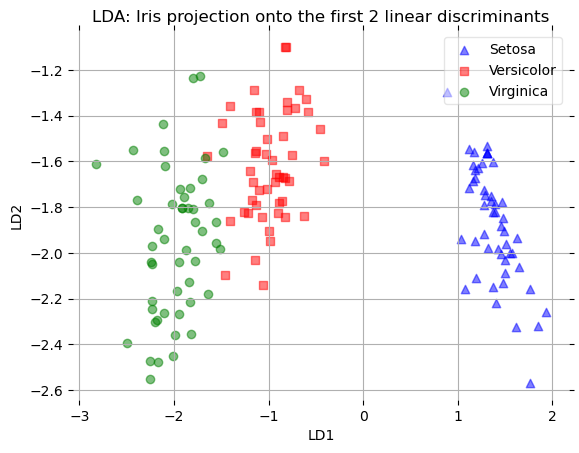

In [14]:
from matplotlib import pyplot as plt

def plot_step_lda():

    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X_lda[:,0].real[y == label],
                y=X_lda[:,1].real[y == label],
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label]
                )

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('LDA: Iris projection onto the first 2 linear discriminants')

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.grid()
    plt.tight_layout
    plt.show()

plot_step_lda()